# Imports + General

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import random
import os

import tqdm

import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.utils.data as data
import torchvision.datasets
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import conv3x3, _resnet, ResNet18_Weights
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = 'cpu' # torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths to data
kkanji_150_path = "/mnt/d/Bachelor_work/data_for_model/kkanji2_150"
kkanji_200_path = "/mnt/d/Bachelor_work/data_for_model/kkanji2_200"
kkanji_300_path = "/mnt/d/Bachelor_work/data_for_model/kkanji2_300"

# PreactBasicBlock

In [2]:
class PreactBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(PreactBasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')

        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1

        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)

        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out
    
    # Check what is model params and conv3x3. Also normlayer is not used.

# Cycle func

In [3]:
def are_weigths_unequal(old_weigths, new_weigths):
    return bool(len([1 for w1, w2 in zip(old_weigths, new_weigths) if not torch.all(w1.eq(w2))]))

def cycle(model, loader, criterion, train=False, optimizer=None):
    overall_loss = []
    overall_accuracy = []
    dataloader_iterator = iter(loader)

    if train:
        model.train()
    else:
        model.eval()

    model_weigths = list(model.state_dict().values())

    for batch_id in tqdm.tqdm_notebook(range(len(loader))):   
        try:
            X_batch, y_batch = next(dataloader_iterator)
        except:
            dataloader_iterator = iter(loader)
            X_batch, y_batch = next(dataloader_iterator)

        # if batch_id == 2:
        #     if train:
        #         assert are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Model is not training"
                
        #     else:
        #         assert not are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Weigths are chaning while validating"

        #     del model_weigths
    
        # X_batch = X_batch.to(device)
        # y_batch = y_batch.to(device)

        if train:
            optimizer.zero_grad()
            preds = model(X_batch)

            # print("Preds require grad: ", preds.requires_grad)

            loss_value = criterion(preds, y_batch)

            # print("Loss value require grad: ", loss_value.requires_grad)

            loss_value.backward()

            # Check weights
            # new_model_weights = list(model.state_dict().values())
            # print("Model weights require grad (before step): ", new_model_weights[0].requires_grad)

            # for param in model.parameters():
            #     print(param.grad.data.sum())
    
            optimizer.step()

            # for param in model.parameters():
            #     print(param.grad.data.sum())

            # Check weights again after optimizer step
            # new_model_weights = list(model.state_dict().values())
            # print("Model weights require grad (after step): ", new_model_weights[0].requires_grad)

        else:
            with torch.no_grad():
                preds = model(X_batch)
                loss_value = criterion(preds, y_batch).mean()

        overall_loss.append(loss_value.mean())

        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
        overall_accuracy.append(accuracy)

    mean_loss = sum(overall_loss) / len(loader)
    mean_accuracy = sum(overall_accuracy) / len(loader)
    
    return mean_loss.item(), mean_accuracy.item()

In [4]:
w1 = [torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6])]
w2 = [torch.tensor([1, 2, 3]), torch.tensor([4, 6, 6])]
assert are_weigths_unequal(w1, w2), "Weigths are equal"

# Dataloaders

In [28]:
# Dataset initialization

def get_dataloaders(batch_size: int = 16, classamount: int = 150):

    # Define transformations
    my_transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)
            ])

    if classamount == 150:
        # Load dataset 150
        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=my_transform)

    elif classamount == 200:
        # Load dataset 200
        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=my_transform)

    elif classamount == 300:
        # Load dataset 300
        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=my_transform)

    # Split dataset into training and testing sets
    train_indices, test_indices = train_test_split(
        list(range(len(full_dataset))),
        test_size=0.3,
        stratify=[label for _, label in full_dataset.samples]
    )

    train_dataset = data.Subset(full_dataset, train_indices)
    test_dataset = data.Subset(full_dataset, test_indices)

    # Calculate class weights for the training set
    class_counts = [0] * len(full_dataset.classes)
    for idx in train_indices:
        _, label = full_dataset.samples[idx]
        class_counts[label] += 1

    class_weights = [1.0 / count for count in class_counts]
    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]

    # Create a WeightedRandomSampler for the training set
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoaders
    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader, full_dataset


# Testing models

In [36]:
# Testing loop
def testing_model(class_amount: int = 150, model_suff_path: str = None):

    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False) # 'resnet18'
    model.fc = nn.Linear(model.fc.in_features, class_amount)

    if model_suff_path is not None:
        if os.path.exists(f"{model_suff_path}/model.pth"):
            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))

    else:
        if os.path.exists(f"model_{class_amount}_stuff/model.pth"):
            model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))

    criterion = nn.CrossEntropyLoss()

    trainloader, testloader, original_dataset = get_dataloaders(classamount=class_amount)

    test_loss, test_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion)

    print('Test: loss', test_loss, 'accuracy', test_accuracy)

    #Accuracy for each class
    class_correct = list(0. for i in range(class_amount))

    class_total = list(0. for i in range(class_amount))

    model.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # Print accuracy for each class using class names
    class_correct_dict = {}
    class_total_dict = {}

    for i in range(class_amount):
        class_correct_dict[original_dataset.classes[i]] = class_correct[i] / class_total[i]
        class_total_dict[original_dataset.classes[i]] = class_total[i]

    class_correct_dict = dict(sorted(class_correct_dict.items(), key=lambda item: item[1], reverse=True))

    for key, value in class_correct_dict.items():
        print(key, value, class_total_dict[key])



# Getting stuff for training

In [6]:
def getting_stuff_for_training(classamount: int = 150, pathes: dict = None, lr: float = 1e-3, scheduler_step_size: int = 10, scheduler_gamma: float = 0.1, weights = None):    
    stuff = {}
    last_epoch = 0
    if os.path.exists(pathes["last_epoch"]):
        last_epoch = np.load(pathes["last_epoch"])
    stuff["last_epoch"] = last_epoch
    
    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], weights, False) # 'resnet18'

    if weights is not None:
        for param in model.parameters():
            param.requires_grad = False

    if classamount == 150:
        model.fc = nn.Linear(model.fc.in_features, 150)

    elif classamount == 200:
        model.fc = nn.Linear(model.fc.in_features, 200)

    elif classamount == 300:
        model.fc = nn.Linear(model.fc.in_features, 300)

    if weights is not None:
        for param in model.fc.parameters():
            param.requires_grad = True

    if os.path.exists(pathes["model"]):
        model.load_state_dict(torch.load(pathes["model"]))

    #model = model.to(device)
    stuff["model"] = model

    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # , weight_decay=0.)
    if os.path.exists(pathes["optimizer"]):
        optimizer.load_state_dict(torch.load(pathes["optimizer"]))
    stuff["optimizer"] = optimizer

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)
    if os.path.exists(pathes["scheduler"]):
        scheduler.load_state_dict(torch.load(pathes["scheduler"]))
    stuff["scheduler"] = scheduler

    train_loss_history = []
    if os.path.exists(pathes["train_loss_history"]):
        train_loss_history = list(np.load(pathes["train_loss_history"]))
    stuff["train_loss_history"] = train_loss_history

    train_accuracy_history = []
    if os.path.exists(pathes["train_accuracy_history"]):
        train_accuracy_history = list(np.load(pathes["train_accuracy_history"]))
    stuff["train_accuracy_history"] = train_accuracy_history

    val_loss_history = []
    if os.path.exists(pathes["val_loss_history"]):
        val_loss_history = list(np.load(pathes["val_loss_history"]))
    stuff["val_loss_history"] = val_loss_history

    val_accuracy_history = []
    if os.path.exists(pathes["val_accuracy_history"]):
        val_accuracy_history = list(np.load(pathes["val_accuracy_history"]))
    stuff["val_accuracy_history"] = val_accuracy_history

    max_val_accuracy = 0
    if os.path.exists(pathes["max_val_accuracy"]):
        max_val_accuracy = np.load(pathes["max_val_accuracy"])
    stuff["max_val_accuracy"] = max_val_accuracy

    early_stopping = 5
    if os.path.exists(pathes["early_stopping"]):
        early_stopping = np.load(pathes["early_stopping"])
    stuff["early_stopping"] = early_stopping
    
    return stuff

# 150 classes logic

In [7]:
# Training loop
pathes = {"last_epoch": "model_150_stuff/last_epoch.npy", "model": "model_150_stuff/model.pth", 
          "optimizer": "model_150_stuff/optimizer.pth", "scheduler": "model_150_stuff/scheduler.pth", 
          "train_loss_history": "model_150_stuff/train_loss_history.npy", 
          "val_loss_history": "model_150_stuff/val_loss_history.npy", 
          "train_accuracy_history": "model_150_stuff/train_accuracy_history.npy", 
          "val_accuracy_history": "model_150_stuff/val_accuracy_history.npy", 
          "max_val_accuracy": "model_150_stuff/max_val_accuracy.npy", 
          "early_stopping": "model_150_stuff/early_stopping.npy"}

trainloader, testloader, _ = get_dataloaders(classamount=150)

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

last_epoch = stuff["last_epoch"]
epochs = last_epoch + 100

criterion = nn.CrossEntropyLoss()

model = stuff["model"]
optimizer = stuff["optimizer"]
scheduler = stuff["scheduler"]

train_loss_history = stuff["train_loss_history"]
train_accuracy_history = stuff["train_accuracy_history"]

val_loss_history = stuff["val_loss_history"]
val_accuracy_history = stuff["val_accuracy_history"]

max_val_accuracy = stuff["max_val_accuracy"]
early_stopping = stuff["early_stopping"]

for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)): 

    train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer) #train(model, trainloader, criterion, optimizer, batch_size)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    scheduler.step()

    print('Epoch:', epoch+1)
    print('Train: loss', train_loss, 'accuracy', train_accuracy)
    print('Validation: loss', val_loss, 'accuracy', val_accuracy)

    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        early_stopping = 5

        # Save the model
        torch.save(model.state_dict(), 'model_150_stuff/model.pth')

        # Save the optimizer
        torch.save(optimizer.state_dict(), 'model_150_stuff/optimizer.pth')

        # Save the scheduler
        torch.save(scheduler.state_dict(), 'model_150_stuff/scheduler.pth')

        # Save the loss history
        np.save('model_150_stuff/train_loss_history.npy', train_loss_history)
        np.save('model_150_stuff/val_loss_history.npy', val_loss_history)

        # Save the accuracy history
        np.save('model_150_stuff/train_accuracy_history.npy', train_accuracy_history)
        np.save('model_150_stuff/val_accuracy_history.npy', val_accuracy_history)

        # Save the last epoch
        np.save('model_150_stuff/last_epoch.npy', epoch+1)

        # Save max validation accuracy
        np.save('model_150_stuff/max_val_accuracy.npy', max_val_accuracy)

        # Save early stopping
        np.save('model_150_stuff/early_stopping.npy', early_stopping)

    
    else:
        early_stopping -= 1

    if early_stopping == 0:
        break

print('Best validation accuracy for 150 classes:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

/tmp/ipykernel_559908/447459263.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_559908/526678670.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id in tqdm.tqdm_notebook(range(len(loader))):


  0%|          | 0/3089 [00:00<?, ?it/s]

/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 1
Train: loss 0.8587170839309692 accuracy 0.7912552356719971
Validation: loss 0.4841373562812805 accuracy 0.8864237070083618


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 2
Train: loss 0.2766551673412323 accuracy 0.924613356590271
Validation: loss 0.3426608741283417 accuracy 0.9139916896820068


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 3
Train: loss 0.19205038249492645 accuracy 0.946099042892456
Validation: loss 0.25618109107017517 accuracy 0.9386959075927734


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 4
Train: loss 0.14763027429580688 accuracy 0.9605859518051147
Validation: loss 0.25332051515579224 accuracy 0.9439041614532471


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 5
Train: loss 0.1139935851097107 accuracy 0.9691849946975708
Validation: loss 0.27646946907043457 accuracy 0.9414966702461243


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 6
Train: loss 0.09813234955072403 accuracy 0.9734744429588318
Validation: loss 0.2496241331100464 accuracy 0.9490967988967896


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 7
Train: loss 0.08216225355863571 accuracy 0.9779459238052368
Validation: loss 0.24536246061325073 accuracy 0.9549974799156189


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 8
Train: loss 0.08051000535488129 accuracy 0.9797062277793884
Validation: loss 0.2780666947364807 accuracy 0.9490967988967896


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 9
Train: loss 0.06896615028381348 accuracy 0.9820936918258667
Validation: loss 0.30576449632644653 accuracy 0.9494743943214417


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 10
Train: loss 0.0701572448015213 accuracy 0.9830851554870605
Validation: loss 0.24283261597156525 accuracy 0.9564451575279236


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 11
Train: loss 0.02153966762125492 accuracy 0.9945573210716248
Validation: loss 0.1807313859462738 accuracy 0.9695367217063904


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 12
Train: loss 0.008620446547865868 accuracy 0.9976327419281006
Validation: loss 0.17533139884471893 accuracy 0.9719914197921753


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 13
Train: loss 0.0060370066203176975 accuracy 0.9985836744308472
Validation: loss 0.1735859364271164 accuracy 0.9725894331932068


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 14
Train: loss 0.003699559485539794 accuracy 0.9991299510002136
Validation: loss 0.1717766523361206 accuracy 0.9743044972419739


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 15
Train: loss 0.003922520205378532 accuracy 0.9990692734718323
Validation: loss 0.17799171805381775 accuracy 0.9734075665473938


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 16
Train: loss 0.003396973479539156 accuracy 0.9991299510002136
Validation: loss 0.17712731659412384 accuracy 0.974682092666626


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 17
Train: loss 0.003082391107454896 accuracy 0.9991906881332397
Validation: loss 0.17997315526008606 accuracy 0.9748709201812744


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 18
Train: loss 0.0025213679764419794 accuracy 0.9993121027946472
Validation: loss 0.18840292096138 accuracy 0.9744933247566223


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 19
Train: loss 0.0030269490089267492 accuracy 0.9992716312408447
Validation: loss 0.18177184462547302 accuracy 0.9752957820892334


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 20
Train: loss 0.002144465921446681 accuracy 0.9994040727615356
Validation: loss 0.18285706639289856 accuracy 0.975579023361206


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 21
Train: loss 0.001609179424121976 accuracy 0.9995144009590149
Validation: loss 0.1871107816696167 accuracy 0.9752485752105713


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 22
Train: loss 0.0019120327197015285 accuracy 0.9995750784873962
Validation: loss 0.1865675449371338 accuracy 0.9752957820892334


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 23
Train: loss 0.001350375940091908 accuracy 0.9995750784873962
Validation: loss 0.1896047294139862 accuracy 0.9760982990264893


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 24
Train: loss 0.0009683629614301026 accuracy 0.9997167587280273
Validation: loss 0.1811934858560562 accuracy 0.9759566783905029


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 25
Train: loss 0.0007068119011819363 accuracy 0.9997976422309875
Validation: loss 0.1880798041820526 accuracy 0.9763815402984619


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 26
Train: loss 0.0010179176460951567 accuracy 0.9997167587280273
Validation: loss 0.18351784348487854 accuracy 0.976003885269165


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 27
Train: loss 0.0023441037628799677 accuracy 0.9995144009590149
Validation: loss 0.18614207208156586 accuracy 0.9760982990264893


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 28
Train: loss 0.0013877344317734241 accuracy 0.9996358156204224
Validation: loss 0.1836719661951065 accuracy 0.9759094715118408


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 29
Train: loss 0.001118599553592503 accuracy 0.9996560215950012
Validation: loss 0.18309812247753143 accuracy 0.9760982990264893


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 30
Train: loss 0.0012536599533632398 accuracy 0.9996155500411987
Validation: loss 0.18655148148536682 accuracy 0.9768535494804382


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 31
Train: loss 0.0012560250470414758 accuracy 0.9996560215950012
Validation: loss 0.18824657797813416 accuracy 0.9765231609344482


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 32
Train: loss 0.0008508210303261876 accuracy 0.9997572302818298
Validation: loss 0.18583030998706818 accuracy 0.976003885269165


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 33
Train: loss 0.0011308419052511454 accuracy 0.9996155500411987
Validation: loss 0.1851164549589157 accuracy 0.9766175150871277


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 34
Train: loss 0.0005384648684412241 accuracy 0.9998583793640137
Validation: loss 0.1917487382888794 accuracy 0.9759094715118408


  0%|          | 0/3089 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Epoch: 35
Train: loss 0.0011577833211049438 accuracy 0.9996358156204224
Validation: loss 0.18794189393520355 accuracy 0.9760982990264893
Best validation accuracy for 150 classes: 0.9768535494804382 Epoch 30


Text(0.5, 1.0, 'Accuracy for 150 classes')

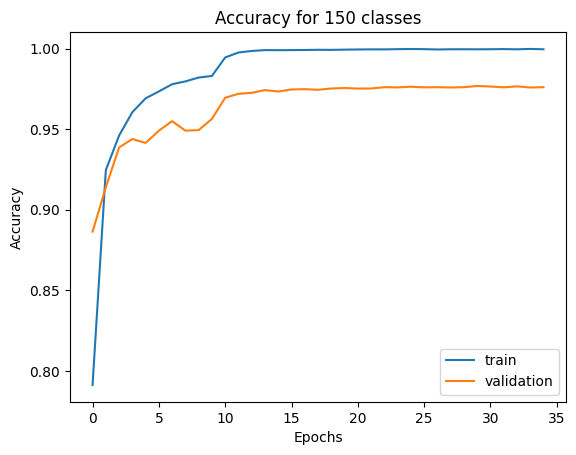

In [8]:
plt.plot(train_accuracy_history, label="train")
plt.plot(val_accuracy_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for 150 classes')

Text(0.5, 1.0, 'Loss for 150 classes')

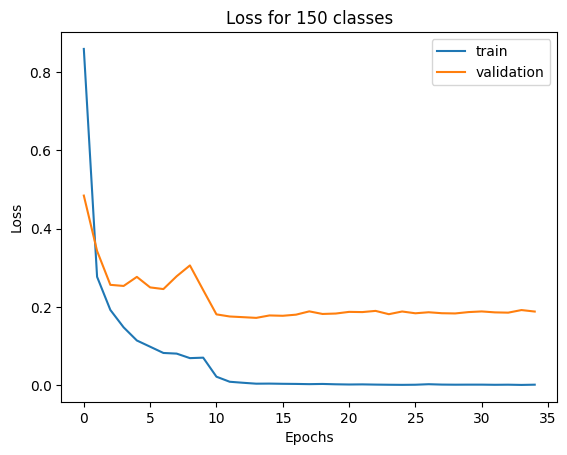

In [9]:
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for 150 classes')

In [37]:
# Testing model
testing_model(class_amount=150)

/tmp/ipykernel_559908/2342485006.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))
/tmp/ipykerne

  0%|          | 0/1324 [00:00<?, ?it/s]

Test: loss 0.06250082701444626 accuracy 0.9920222759246826
U+4E00 1.0 530.0
U+4E03 1.0 77.0
U+4E0B 1.0 150.0
U+4E0D 1.0 68.0
U+4E16 1.0 146.0
U+4E2D 1.0 237.0
U+4EAC 1.0 67.0
U+4ECA 1.0 199.0
U+4ED5 1.0 138.0
U+4ED8 1.0 86.0
U+4F55 1.0 218.0
U+5207 1.0 94.0
U+5341 1.0 161.0
U+5375 1.0 59.0
U+53D6 1.0 112.0
U+5408 1.0 175.0
U+56DB 1.0 131.0
U+5869 1.0 67.0
U+591C 1.0 116.0
U+5B50 1.0 310.0
U+5C45 1.0 115.0
U+5C71 1.0 164.0
U+5DE6 1.0 76.0
U+5F15 1.0 95.0
U+5FA1 1.0 191.0
U+5FC3 1.0 184.0
U+601D 1.0 115.0
U+6238 1.0 113.0
U+65B9 1.0 261.0
U+660E 1.0 60.0
U+662F 1.0 246.0
U+6642 1.0 200.0
U+6728 1.0 117.0
U+6851 1.0 88.0
U+6C17 1.0 66.0
U+6C41 1.0 158.0
U+6C5F 1.0 119.0
U+713C 1.0 63.0
U+716E 1.0 73.0
U+7389 1.0 61.0
U+7406 1.0 69.0
U+7530 1.0 59.0
U+7533 1.0 139.0
U+7537 1.0 70.0
U+767D 1.0 113.0
U+795E 1.0 76.0
U+79C1 1.0 65.0
U+7D19 1.0 79.0
U+7D66 1.0 157.0
U+8272 1.0 112.0
U+8695 1.0 156.0
U+897F 1.0 96.0
U+898B 1.0 320.0
U+8A9E 1.0 61.0
U+8EAB 1.0 166.0
U+901A 1.0 63.0
U+9053 1.0 83

# 200 classes logic

In [10]:
# Training loop

pathes = {"last_epoch": "model_200_stuff/last_epoch.npy", "model": "model_200_stuff/model.pth", 
            "optimizer": "model_200_stuff/optimizer.pth", "scheduler": "model_200_stuff/scheduler.pth", 
            "train_loss_history": "model_200_stuff/train_loss_history.npy", 
            "val_loss_history": "model_200_stuff/val_loss_history.npy", 
            "train_accuracy_history": "model_200_stuff/train_accuracy_history.npy", 
            "val_accuracy_history": "model_200_stuff/val_accuracy_history.npy", 
            "max_val_accuracy": "model_200_stuff/max_val_accuracy.npy", 
            "early_stopping": "model_200_stuff/early_stopping.npy"}

trainloader, testloader, _ = get_dataloaders(classamount=200)

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

last_epoch = stuff["last_epoch"]
epochs = last_epoch + 100

criterion = nn.CrossEntropyLoss()

model = stuff["model"]
optimizer = stuff["optimizer"]
scheduler = stuff["scheduler"]

train_loss_history = stuff["train_loss_history"]
train_accuracy_history = stuff["train_accuracy_history"]

val_loss_history = stuff["val_loss_history"]
val_accuracy_history = stuff["val_accuracy_history"]

max_val_accuracy = stuff["max_val_accuracy"]
early_stopping = stuff["early_stopping"]

for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)):
    train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer) #train(model, trainloader, criterion, optimizer, batch_size)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    scheduler.step()

    print('Epoch:', epoch+1)
    print('Train: loss', train_loss, 'accuracy', train_accuracy)
    print('Validation: loss', val_loss, 'accuracy', val_accuracy)

    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        early_stopping = 5

        # Save the model
        torch.save(model.state_dict(), 'model_200_stuff/model.pth')

        # Save the optimizer
        torch.save(optimizer.state_dict(), 'model_200_stuff/optimizer.pth')

        # Save the scheduler
        torch.save(scheduler.state_dict(), 'model_200_stuff/scheduler.pth')

        # Save the loss history
        np.save('model_200_stuff/train_loss_history.npy', train_loss_history)
        np.save('model_200_stuff/val_loss_history.npy', val_loss_history)

        # Save the accuracy history
        np.save('model_200_stuff/train_accuracy_history.npy', train_accuracy_history)
        np.save('model_200_stuff/val_accuracy_history.npy', val_accuracy_history)

        # Save the last epoch
        np.save('model_200_stuff/last_epoch.npy', epoch+1)

        # Save max validation accuracy
        np.save('model_200_stuff/max_val_accuracy.npy', max_val_accuracy)

        # Save early stopping
        np.save('model_200_stuff/early_stopping.npy', early_stopping)

    else:
        early_stopping -= 1

    if early_stopping == 0:
        break

print('Best validation accuracy for 200 classes:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

/tmp/ipykernel_559908/420469338.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_559908/526678670.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id in tqdm.tqdm_notebook(range(len(loader))):


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 1
Train: loss 0.9437909126281738 accuracy 0.7765326499938965
Validation: loss 0.4440138339996338 accuracy 0.8896339535713196


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 2
Train: loss 0.2996995151042938 accuracy 0.9203115701675415
Validation: loss 0.32356253266334534 accuracy 0.9177631735801697


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 3
Train: loss 0.19762247800827026 accuracy 0.9469346404075623
Validation: loss 0.39575105905532837 accuracy 0.906854510307312


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 4
Train: loss 0.15259432792663574 accuracy 0.9588454365730286
Validation: loss 0.30731746554374695 accuracy 0.9322425127029419


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 5
Train: loss 0.12611420452594757 accuracy 0.9662196636199951
Validation: loss 0.2762238383293152 accuracy 0.942363977432251


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 6
Train: loss 0.10265880078077316 accuracy 0.9725455641746521
Validation: loss 0.29592832922935486 accuracy 0.942279577255249


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 7
Train: loss 0.0917668491601944 accuracy 0.9753289222717285
Validation: loss 0.3127976059913635 accuracy 0.9454425573348999


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 8
Train: loss 0.08456942439079285 accuracy 0.9796486496925354
Validation: loss 0.29857495427131653 accuracy 0.9448943138122559


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 9
Train: loss 0.07763747870922089 accuracy 0.9809680581092834
Validation: loss 0.271056592464447 accuracy 0.952808678150177


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 10
Train: loss 0.07077479362487793 accuracy 0.9827031493186951
Validation: loss 0.278209924697876 accuracy 0.9519371390342712


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 11
Train: loss 0.021790344268083572 accuracy 0.9940897822380066
Validation: loss 0.20740953087806702 accuracy 0.9656854867935181


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 12
Train: loss 0.01257807482033968 accuracy 0.9971985220909119
Validation: loss 0.18856686353683472 accuracy 0.9676254391670227


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 13
Train: loss 0.00854464340955019 accuracy 0.9981745481491089
Validation: loss 0.1866898238658905 accuracy 0.9686797261238098


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 14
Train: loss 0.005329831037670374 accuracy 0.9986444711685181
Validation: loss 0.18487796187400818 accuracy 0.9697762131690979


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 15
Train: loss 0.004902846645563841 accuracy 0.9990601539611816
Validation: loss 0.18723466992378235 accuracy 0.9697340726852417


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 16
Train: loss 0.004257840104401112 accuracy 0.9991143941879272
Validation: loss 0.18980632722377777 accuracy 0.9707883596420288


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 17
Train: loss 0.0030867760069668293 accuracy 0.9992408752441406
Validation: loss 0.1907588541507721 accuracy 0.9711679220199585


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 18
Train: loss 0.002999375807121396 accuracy 0.9992228150367737
Validation: loss 0.19750970602035522 accuracy 0.9709992408752441


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 19
Train: loss 0.0025732109788805246 accuracy 0.9994758367538452
Validation: loss 0.19333645701408386 accuracy 0.9711679220199585


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 20
Train: loss 0.0020182926673442125 accuracy 0.9995300769805908
Validation: loss 0.1933225393295288 accuracy 0.9717161655426025


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 21
Train: loss 0.0015315162017941475 accuracy 0.9996927380561829
Validation: loss 0.19426345825195312 accuracy 0.9721379280090332


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 22
Train: loss 0.0016333054518327117 accuracy 0.9995661973953247
Validation: loss 0.19551005959510803 accuracy 0.9715896844863892


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 23
Train: loss 0.0015442484291270375 accuracy 0.9995300769805908
Validation: loss 0.1955200731754303 accuracy 0.9720957279205322


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 24
Train: loss 0.001632414641790092 accuracy 0.9995120167732239
Validation: loss 0.1954115927219391 accuracy 0.9724330902099609


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 25
Train: loss 0.0009333789930678904 accuracy 0.9997469782829285
Validation: loss 0.19451366364955902 accuracy 0.9721379280090332


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 26
Train: loss 0.0012463227612897754 accuracy 0.9996204376220703
Validation: loss 0.1909976452589035 accuracy 0.9724330902099609


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 27
Train: loss 0.001291527645662427 accuracy 0.9996204376220703
Validation: loss 0.19261421263217926 accuracy 0.9721800684928894


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 28
Train: loss 0.0013082775985822082 accuracy 0.9996384978294373
Validation: loss 0.19475586712360382 accuracy 0.9728126525878906


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 29
Train: loss 0.0014413242461159825 accuracy 0.9996023774147034
Validation: loss 0.1902155727148056 accuracy 0.9720957279205322


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 30
Train: loss 0.0009585860534571111 accuracy 0.9996746778488159
Validation: loss 0.19480253756046295 accuracy 0.9731078743934631


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 31
Train: loss 0.001467765774577856 accuracy 0.9995843172073364
Validation: loss 0.19745707511901855 accuracy 0.9723487496376038


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 32
Train: loss 0.0008940088446252048 accuracy 0.9997650384902954
Validation: loss 0.19644618034362793 accuracy 0.9727283120155334


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 33
Train: loss 0.0015715654008090496 accuracy 0.9995661973953247
Validation: loss 0.19327902793884277 accuracy 0.9724752902984619


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 34
Train: loss 0.0011381931835785508 accuracy 0.9996746778488159
Validation: loss 0.1985638439655304 accuracy 0.972981333732605


  0%|          | 0/3458 [00:00<?, ?it/s]

  0%|          | 0/1482 [00:00<?, ?it/s]

Epoch: 35
Train: loss 0.0010454949224367738 accuracy 0.9996204376220703
Validation: loss 0.19636370241641998 accuracy 0.9726861715316772
Best validation accuracy for 200 classes: 0.9731078743934631 Epoch 30


Text(0.5, 1.0, 'Accuracy for 200 classes')

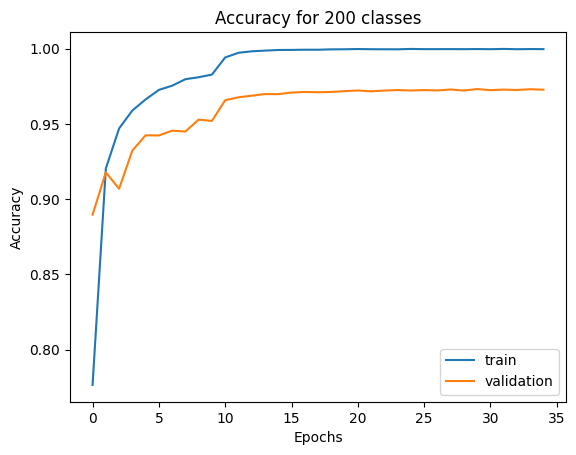

In [11]:
plt.plot(train_accuracy_history, label="train")
plt.plot(val_accuracy_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for 200 classes')

Text(0.5, 1.0, 'Loss for 200 classes')

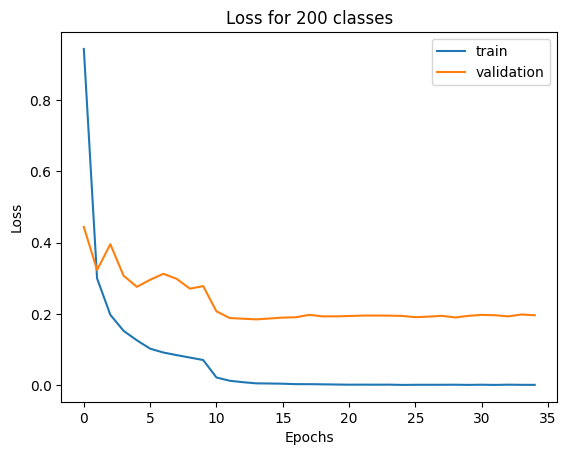

In [12]:
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for 200 classes')

In [38]:
# Testing model
testing_model(class_amount=200)

/tmp/ipykernel_559908/2342485006.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))
/tmp/ipykerne

  0%|          | 0/1482 [00:00<?, ?it/s]

Test: loss 0.06293825060129166 accuracy 0.9908485412597656
U+4E00 1.0 530.0
U+4E03 1.0 77.0
U+4E09 1.0 238.0
U+4E0B 1.0 150.0
U+4E16 1.0 146.0
U+4E5D 1.0 50.0
U+4E8C 1.0 200.0
U+4E91 1.0 530.0
U+4E94 1.0 165.0
U+4ECA 1.0 199.0
U+4F55 1.0 218.0
U+516D 1.0 121.0
U+5171 1.0 48.0
U+5341 1.0 161.0
U+53CA 1.0 77.0
U+540D 1.0 129.0
U+5473 1.0 98.0
U+547C 1.0 52.0
U+548C 1.0 94.0
U+5730 1.0 55.0
U+591A 1.0 58.0
U+5929 1.0 79.0
U+592A 1.0 66.0
U+5965 1.0 48.0
U+5973 1.0 216.0
U+5BB6 1.0 116.0
U+5C11 1.0 61.0
U+5C45 1.0 115.0
U+5DDD 1.0 59.0
U+5DDE 1.0 126.0
U+5EA7 1.0 46.0
U+5F80 1.0 51.0
U+5F8C 1.0 125.0
U+60AA 1.0 48.0
U+61F8 1.0 56.0
U+6210 1.0 73.0
U+6216 1.0 60.0
U+6238 1.0 113.0
U+6545 1.0 49.0
U+660E 1.0 60.0
U+662F 1.0 246.0
U+6642 1.0 200.0
U+6851 1.0 88.0
U+6C41 1.0 158.0
U+6C5F 1.0 119.0
U+6CD5 1.0 51.0
U+6D77 1.0 52.0
U+713C 1.0 63.0
U+714E 1.0 59.0
U+7389 1.0 61.0
U+7406 1.0 69.0
U+751F 1.0 128.0
U+7530 1.0 59.0
U+7537 1.0 70.0
U+795E 1.0 76.0
U+7A2E 1.0 73.0
U+7ACB 1.0 156.0
U+7AF

# 300 classes logic

In [13]:
# Training loop

pathes = {"last_epoch": "model_300_stuff/last_epoch.npy", "model": "model_300_stuff/model.pth",
            "optimizer": "model_300_stuff/optimizer.pth", "scheduler": "model_300_stuff/scheduler.pth",
            "train_loss_history": "model_300_stuff/train_loss_history.npy",
            "val_loss_history": "model_300_stuff/val_loss_history.npy",
            "train_accuracy_history": "model_300_stuff/train_accuracy_history.npy",
            "val_accuracy_history": "model_300_stuff/val_accuracy_history.npy",
            "max_val_accuracy": "model_300_stuff/max_val_accuracy.npy",
            "early_stopping": "model_300_stuff/early_stopping.npy"}

trainloader, testloader, _ = get_dataloaders(classamount=300)

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

last_epoch = stuff["last_epoch"]
epochs = last_epoch + 100

criterion = nn.CrossEntropyLoss()

model = stuff["model"]
optimizer = stuff["optimizer"]
scheduler = stuff["scheduler"]

train_loss_history = stuff["train_loss_history"]
train_accuracy_history = stuff["train_accuracy_history"]

val_loss_history = stuff["val_loss_history"]
val_accuracy_history = stuff["val_accuracy_history"]

max_val_accuracy = stuff["max_val_accuracy"]
early_stopping = stuff["early_stopping"]

for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)):
    train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer) #train(model, trainloader, criterion, optimizer, batch_size)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    scheduler.step()

    print('Epoch:', epoch+1)
    print('Train: loss', train_loss, 'accuracy', train_accuracy)
    print('Validation: loss', val_loss, 'accuracy', val_accuracy)

    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        early_stopping = 5

        # Save the model
        torch.save(model.state_dict(), 'model_300_stuff/model.pth')

        # Save the optimizer
        torch.save(optimizer.state_dict(), 'model_300_stuff/optimizer.pth')

        # Save the scheduler
        torch.save(scheduler.state_dict(), 'model_300_stuff/scheduler.pth')

        # Save the loss history
        np.save('model_300_stuff/train_loss_history.npy', train_loss_history)
        np.save('model_300_stuff/val_loss_history.npy', val_loss_history)

        # Save the accuracy history
        np.save('model_300_stuff/train_accuracy_history.npy', train_accuracy_history)
        np.save('model_300_stuff/val_accuracy_history.npy', val_accuracy_history)

        # Save the last epoch
        np.save('model_300_stuff/last_epoch.npy', epoch+1)

        # Save max validation accuracy
        np.save('model_300_stuff/max_val_accuracy.npy', max_val_accuracy)

        # Save early stopping
        np.save('model_300_stuff/early_stopping.npy', early_stopping)

    else:
        early_stopping -= 1

    if early_stopping == 0:
        break
    
print('Best validation accuracy for 300 classes:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

/tmp/ipykernel_559908/3895318782.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_559908/526678670.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id in tqdm.tqdm_notebook(range(len(loader))):


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 1
Train: loss 1.0754785537719727 accuracy 0.7531213164329529
Validation: loss 0.5492537617683411 accuracy 0.8692094087600708


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 2
Train: loss 0.31811273097991943 accuracy 0.9147086143493652
Validation: loss 0.5006927251815796 accuracy 0.89108806848526


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 3
Train: loss 0.21837656199932098 accuracy 0.9413134455680847
Validation: loss 0.389711856842041 accuracy 0.9135209918022156


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 4
Train: loss 0.16419170796871185 accuracy 0.9553794860839844
Validation: loss 0.3174750804901123 accuracy 0.9310239553451538


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 5
Train: loss 0.13563385605812073 accuracy 0.9642210006713867
Validation: loss 0.3580518364906311 accuracy 0.9278515577316284


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 6
Train: loss 0.10896213352680206 accuracy 0.9708208441734314
Validation: loss 0.32663729786872864 accuracy 0.9375874996185303


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 7
Train: loss 0.09965915232896805 accuracy 0.973770260810852
Validation: loss 0.39551761746406555 accuracy 0.9297038912773132


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 8
Train: loss 0.0907597541809082 accuracy 0.976978600025177
Validation: loss 0.36185508966445923 accuracy 0.9372811913490295


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 9
Train: loss 0.08086243271827698 accuracy 0.9796355366706848
Validation: loss 0.33747202157974243 accuracy 0.9430060982704163


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 10
Train: loss 0.07965116202831268 accuracy 0.9794323444366455
Validation: loss 0.3261912763118744 accuracy 0.9458795785903931


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 11
Train: loss 0.026031598448753357 accuracy 0.9932951927185059
Validation: loss 0.24704484641551971 accuracy 0.9614352583885193


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 12
Train: loss 0.013387457467615604 accuracy 0.9966866970062256
Validation: loss 0.23362676799297333 accuracy 0.9640752673149109


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 13
Train: loss 0.009446211159229279 accuracy 0.9978275895118713
Validation: loss 0.2433527261018753 accuracy 0.9643888473510742


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 14
Train: loss 0.005240343045443296 accuracy 0.9986246824264526
Validation: loss 0.24591262638568878 accuracy 0.96573805809021


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 15
Train: loss 0.005692370235919952 accuracy 0.9987028241157532
Validation: loss 0.2384513020515442 accuracy 0.9670143127441406


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 16
Train: loss 0.004970502573996782 accuracy 0.9989372491836548
Validation: loss 0.23659558594226837 accuracy 0.9663798213005066


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 17
Train: loss 0.002852107398211956 accuracy 0.9992810487747192
Validation: loss 0.24884560704231262 accuracy 0.9666496515274048


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 18
Train: loss 0.0034111582208424807 accuracy 0.9991560578346252
Validation: loss 0.24384576082229614 accuracy 0.9669632315635681


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 19
Train: loss 0.002245430601760745 accuracy 0.9994842410087585
Validation: loss 0.2478155940771103 accuracy 0.9667226076126099


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 20
Train: loss 0.002871900796890259 accuracy 0.9993748664855957
Validation: loss 0.2514086067676544 accuracy 0.9674372673034668


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 21
Train: loss 0.0025703818537294865 accuracy 0.9994217157363892
Validation: loss 0.24955256283283234 accuracy 0.9674372673034668


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 22
Train: loss 0.001461467007175088 accuracy 0.9995936751365662
Validation: loss 0.2502288222312927 accuracy 0.9680571556091309


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 23
Train: loss 0.001433791359886527 accuracy 0.9995936751365662
Validation: loss 0.2481355220079422 accuracy 0.96875


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 24
Train: loss 0.0016710052732378244 accuracy 0.9994686245918274
Validation: loss 0.24589699506759644 accuracy 0.9683124423027039


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 25
Train: loss 0.0018325885757803917 accuracy 0.9994686245918274
Validation: loss 0.2478887289762497 accuracy 0.9685676693916321


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 26
Train: loss 0.001129503478296101 accuracy 0.999703049659729
Validation: loss 0.24546146392822266 accuracy 0.9682394862174988


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 27
Train: loss 0.0010122029343619943 accuracy 0.9997499585151672
Validation: loss 0.24782055616378784 accuracy 0.9686770439147949


  0%|          | 0/3999 [00:00<?, ?it/s]

  0%|          | 0/1714 [00:00<?, ?it/s]

Epoch: 28
Train: loss 0.001005924423225224 accuracy 0.9997342824935913
Validation: loss 0.2504226863384247 accuracy 0.9686041474342346
Best validation accuracy for 300 classes: 0.96875 Epoch 23


Text(0.5, 1.0, 'Accuracy for 300 classes')

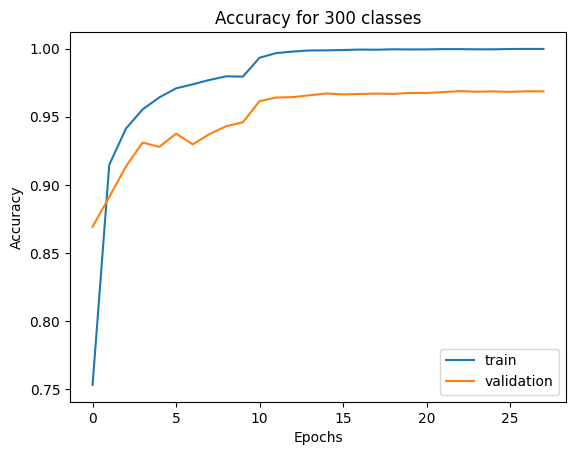

In [14]:
plt.plot(train_accuracy_history, label="train")
plt.plot(val_accuracy_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for 300 classes')

Text(0.5, 1.0, 'Loss for 300 classes')

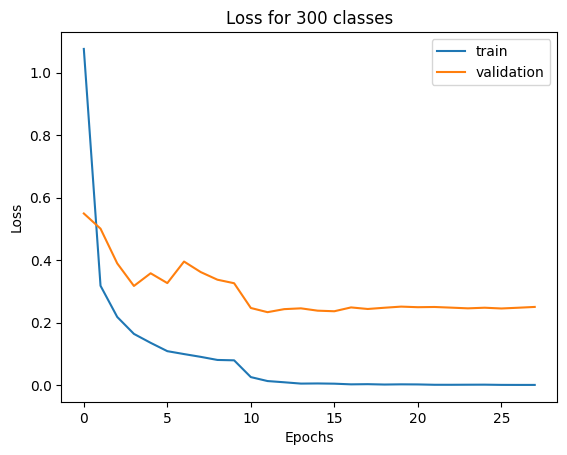

In [15]:
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for 300 classes')

In [39]:
# Testing model
testing_model(class_amount=300)

/tmp/ipykernel_559908/2342485006.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))
/tmp/ipykerne

  0%|          | 0/1714 [00:00<?, ?it/s]

Test: loss 0.07055973261594772 accuracy 0.990738034248352
U+4E03 1.0 77.0
U+4E07 1.0 38.0
U+4E0A 1.0 260.0
U+4E0D 1.0 68.0
U+4E2D 1.0 237.0
U+4E5D 1.0 50.0
U+4ED5 1.0 138.0
U+4EE3 1.0 40.0
U+4F0A 1.0 37.0
U+4F3C 1.0 34.0
U+4F46 1.0 39.0
U+4F50 1.0 36.0
U+4F8D 1.0 48.0
U+4FE1 1.0 37.0
U+5148 1.0 49.0
U+5150 1.0 34.0
U+516B 1.0 77.0
U+5185 1.0 106.0
U+5207 1.0 94.0
U+521D 1.0 46.0
U+52A0 1.0 48.0
U+52E2 1.0 36.0
U+5347 1.0 35.0
U+5357 1.0 40.0
U+5375 1.0 59.0
U+53C8 1.0 435.0
U+53CA 1.0 77.0
U+53D6 1.0 112.0
U+53E4 1.0 64.0
U+53F3 1.0 114.0
U+5409 1.0 147.0
U+540D 1.0 129.0
U+5411 1.0 33.0
U+541B 1.0 33.0
U+547C 1.0 52.0
U+548C 1.0 94.0
U+55B0 1.0 32.0
U+564C 1.0 40.0
U+570B 1.0 74.0
U+5869 1.0 68.0
U+591C 1.0 116.0
U+592A 1.0 66.0
U+592B 1.0 99.0
U+5965 1.0 48.0
U+5BBF 1.0 39.0
U+5C3E 1.0 39.0
U+5C45 1.0 115.0
U+5C4B 1.0 82.0
U+5DDD 1.0 59.0
U+5DDE 1.0 126.0
U+5E2B 1.0 41.0
U+5E73 1.0 64.0
U+5EA7 1.0 46.0
U+5F15 1.0 95.0
U+5F35 1.0 33.0
U+5F62 1.0 51.0
U+5F7C 1.0 43.0
U+5F80 1.0 51.0
U+

# Pretrained 150 classes logic

In [ ]:
# Training loop

pathes = {"last_epoch": "model_pretrained_150_stuff/last_epoch.npy", 
            "model": "model_pretrained_150_stuff/model.pth", 
            "optimizer": "model_pretrained_150_stuff/optimizer.pth", 
            "scheduler": "model_pretrained_150_stuff/scheduler.pth", 
            "train_loss_history": "model_pretrained_150_stuff/train_loss_history.npy", 
            "val_loss_history": "model_pretrained_150_stuff/val_loss_history.npy", 
            "train_accuracy_history": "model_pretrained_150_stuff/train_accuracy_history.npy", 
            "val_accuracy_history": "model_pretrained_150_stuff/val_accuracy_history.npy", 
            "max_val_accuracy": "model_pretrained_150_stuff/max_val_accuracy.npy", 
            "early_stopping": "model_pretrained_150_stuff/early_stopping.npy"}

trainloader, testloader, _ = get_dataloaders(classamount=150)

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, weights=ResNet18_Weights.IMAGENET1K_V1)

last_epoch = stuff["last_epoch"]
epochs = last_epoch + 100

criterion = nn.CrossEntropyLoss()

model = stuff["model"]
optimizer = stuff["optimizer"]
scheduler = stuff["scheduler"]

train_loss_history = stuff["train_loss_history"]
train_accuracy_history = stuff["train_accuracy_history"]

val_loss_history = stuff["val_loss_history"]
val_accuracy_history = stuff["val_accuracy_history"]

max_val_accuracy = stuff["max_val_accuracy"]
early_stopping = stuff["early_stopping"]

for epoch in tqdm.tqdm_notebook(range(last_epoch, epochs)):
    train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer) #train(model, trainloader, criterion, optimizer, batch_size)
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    scheduler.step()

    print('Epoch:', epoch+1)
    print('Train: loss', train_loss, 'accuracy', train_accuracy)
    print('Validation: loss', val_loss, 'accuracy', val_accuracy)

    if val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        early_stopping = 5

        # Save the model
        torch.save(model.state_dict(), 'model_pretrained_150_stuff/model.pth')

        # Save the optimizer
        torch.save(optimizer.state_dict(), 'model_pretrained_150_stuff/optimizer.pth')

        # Save the scheduler
        torch.save(scheduler.state_dict(), 'model_pretrained_150_stuff/scheduler.pth')

        # Save the loss history
        np.save('model_pretrained_150_stuff/train_loss_history.npy', train_loss_history)
        np.save('model_pretrained_150_stuff/val_loss_history.npy', val_loss_history)

        # Save the accuracy history
        np.save('model_pretrained_150_stuff/train_accuracy_history.npy', train_accuracy_history)
        np.save('model_pretrained_150_stuff/val_accuracy_history.npy', val_accuracy_history)

        # Save the last epoch
        np.save('model_pretrained_150_stuff/last_epoch.npy', epoch+1)

        # Save max validation accuracy
        np.save('model_pretrained_150_stuff/max_val_accuracy.npy', max_val_accuracy)

        # Save early stopping
        np.save('model_pretrained_150_stuff/early_stopping.npy', early_stopping)

    else:
        early_stopping -= 1

    if early_stopping == 0:
        break
    
print('Best validation accuracy for 150 pretrained classes:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

In [ ]:
plt.plot(train_accuracy_history, label="train")
plt.plot(val_accuracy_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy for 150 classes pretrained imagenet')

In [ ]:
plt.plot(train_loss_history, label="train")
plt.plot(val_loss_history, label="validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss for 150 classes pretrained imagenet')

In [ ]:
# Testing model
testing_model(class_amount=150, model_suff_path="model_pretrained_150_stuff")